<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/ConvAttenMixer_Proposed_best_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Brain Tumor Classification
# Proposed Method V5 ++
Data Augmnetation
Update in the classification head


In [ ]:
!pip install -U tensorflow-addons
!pip install --upgrade accelerate

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
from google.colab import drive
import tensorflow_addons as tfa

# Prepare the data

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)
NUM_CLASSES = 4
input_shape = (224, 224, 3)

drive.mount('/content/drive', force_remount=True)
# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    #directory='Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# validation data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    #directory='Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Mounted at /content/drive
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
#Rescale pixel values

rescale = tf.keras.layers.Rescaling(scale=1.0 / 255)

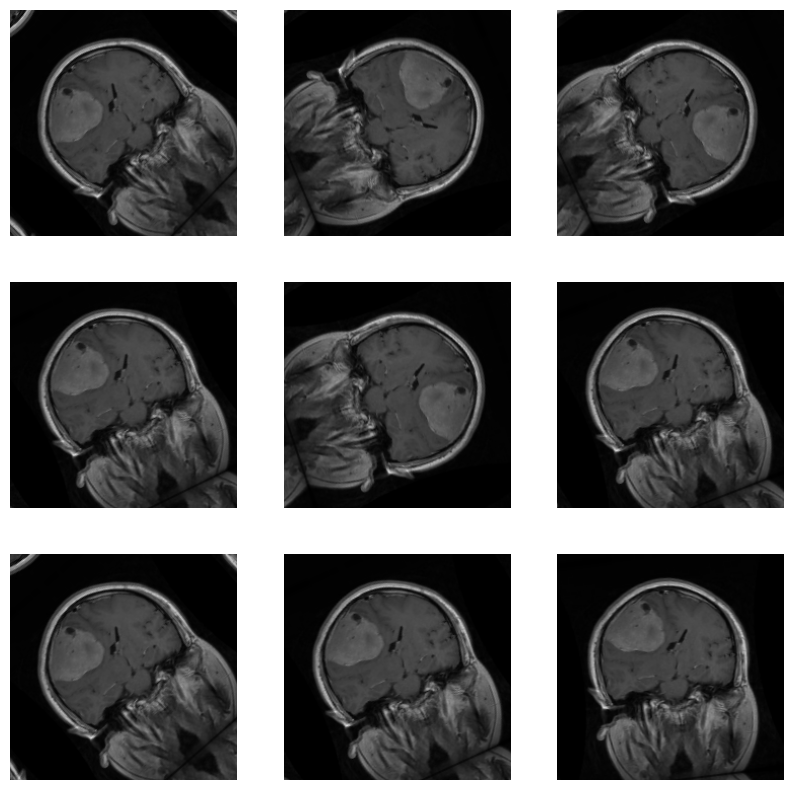

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Hyperparameters



In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
label_smoothing = 0.1

filters=256
depth=8
kernel_size=5
num_epochs = 30
patch_size = 4  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2

#num_transformer_blocks = 8  # Number of repetitions of the transformer layer
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 4 X 4 = 16 
Patches per image: 3136


# Patch extraction and embedding : encoding layer

In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

# External attention block

In [ ]:
def external_attention(x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

# Implement Conv.1D block

In [ ]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in https://arxiv.org/abs/1709.01507.
    Args:
        ratio: The ratio with which the feature map needs to be reduced in the reduction phase.
    Inputs:
        Convolutional features.
    Outputs:
        Attention modified feature maps.
    """
    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

def conv1d(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Conv1D(mlp_dim,2, padding="same")(x)
    x = layers.Conv1D(embedding_dim, 2, padding="same")(x)
    SqueezeExcite(x)
    x = layers.Conv1D(embedding_dim, 3, padding="same")(x)
    return x
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

# ConvMixer utilities

The model used in this experiment is termed as ConvMixer-256/8 where 256 denotes the number of channels and 8 denotes the depth. The resulting model only has 0.8 million parameters.


In [ ]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv1D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv1D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.
    # Pointwise convolution.
    x = layers.Conv1D(filters, kernel_size=1)(x)
    x = activation_block(x)
    return x

def get_conv_mixer_256_8(x):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    x = layers.Rescaling(scale=1.0 / 255)(x)
    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)
    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)
    return x


# Proposed combined (ConvMixer, SA, EA) model




In [ ]:
def get_model():
    #global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    inputs = keras.Input(shape=input_shape)
    x = inputs

    ################## STEP 1 : Patch Embedding ##################
    # Extract patches
    x = PatchExtract(patch_size)(x)
    # Create patch embedding
    x = PatchEmbedding(num_patches, embedding_dim)(x)

    ################## STEP 2 : ConvMixer      ##################
    x = get_conv_mixer_256_8(x)

    ################## STEP 3 : Self-attention ##################
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])

     ################## STEP 4 : ConvMixer      ##################
    x = get_conv_mixer_256_8(x)

    ################## STEP 5 : External attention ##################
    x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)

    # Classification block
    x = conv1d(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    x = layers.GlobalAvgPool1D()(x)
    #x = tf.keras.layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 patch_extract_1 (PatchExtr  (None, 3136, 48)             0         ['input_2[0][0]']             
 act)                                                                                             
                                                                                                  
 patch_embedding_1 (PatchEm  (None, 3136, 64)             203840    ['patch_extract_1[0][0]']     
 bedding)                                                                                         
                                                                                            

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5),
    ],
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=num_epochs
)

Epoch 1/30
179/179 [==============================] - 31s 93ms/step - loss: 0.9447 - accuracy: 0.6679 - precision_1: 0.7789 - recall_1: 0.5347 - f1_score: 0.6073 - val_loss: 2.1234 - val_accuracy: 0.3089 - val_precision_1: 0.3089 - val_recall_1: 0.3089 - val_f1_score: 0.1180
Epoch 2/30
179/179 [==============================] - 15s 81ms/step - loss: 0.7087 - accuracy: 0.8123 - precision_1: 0.8476 - recall_1: 0.7575 - f1_score: 0.7885 - val_loss: 2.1816 - val_accuracy: 0.3089 - val_precision_1: 0.3089 - val_recall_1: 0.3089 - val_f1_score: 0.1180
Epoch 3/30
179/179 [==============================] - 15s 81ms/step - loss: 0.6353 - accuracy: 0.8528 - precision_1: 0.8803 - recall_1: 0.8216 - f1_score: 0.8432 - val_loss: 3.0937 - val_accuracy: 0.3089 - val_precision_1: 0.3089 - val_recall_1: 0.3089 - val_f1_score: 0.1180
Epoch 4/30
179/179 [==============================] - 15s 81ms/step - loss: 0.5810 - accuracy: 0.8831 - precision_1: 0.9018 - recall_1: 0.8573 - f1_score: 0.8731 - val_loss

# Let's visualize the training progress of the model.


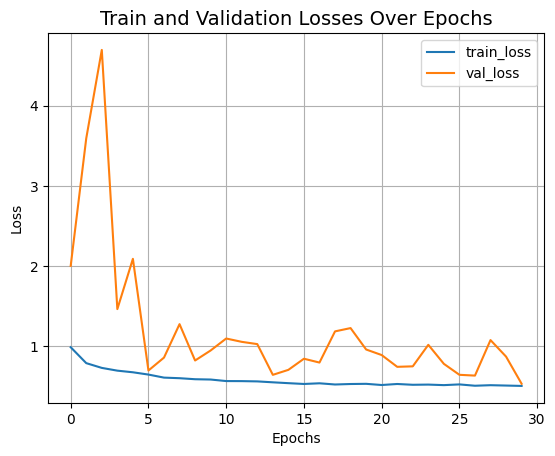

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()